# 03 - Risk Parity Optimization
## Risk Parity Portfolio Project

**Objective**: Optimize portfolio for equal risk contribution

### Sections:
1. Optimize risk parity portfolio
2. Compare with benchmark portfolios (60/40, Equal-Weight)
3. Visualize risk contributions
4. Analyze allocation differences

In [14]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import DataLoader
from src.risk_models import RiskModels
from src.optimizer import PortfolioOptimizer
from src.visualization import PortfolioVisualizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
STONKS_GREEN = '#00ff9c'
STONKS_RED = '#ff005c'
STONKS_BLUE = '#00c3ff'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Load Data & Calculate Covariance

In [16]:
# Load data
loader = DataLoader(fred_api_key="9fb3507ccba20e766e4972a45c57c18c")
prices = loader.load_data('../data/raw_prices.csv')
returns = RiskModels.calculate_returns(prices, method='log')

# Calculate covariance matrix
cov_matrix = RiskModels.calculate_covariance_matrix(returns)

print(f"✅ Data loaded: {returns.shape[0]} days, {returns.shape[1]} assets")
print(f"✅ Covariance matrix: {cov_matrix.shape}")


📂 Loaded cached data → (2567, 3)
✅ Data loaded: 2566 days, 3 assets
✅ Covariance matrix: (3, 3)


## 2. Optimize Risk Parity Portfolio

In [18]:
# Initialize optimizer
optimizer = PortfolioOptimizer(cov_matrix, asset_names=list(returns.columns))

# Optimize for risk parity
print("🔧 Optimizing Risk Parity Portfolio...\n")
rp_result = optimizer.optimize_risk_parity()

# Display results
print("✅ Optimization Complete!\n")
print(f"Success: {rp_result['success']}")
print(f"Objective Value: {rp_result['objective_value']:.6f}")
print(f"Portfolio Volatility: {rp_result['portfolio_volatility']:.4f}")

🔧 Optimizing Risk Parity Portfolio...

✅ Optimization Complete!

Success: True
Objective Value: 0.000000
Portfolio Volatility: 0.1430


In [20]:
# Display weights
print("\n📊 Risk Parity Weights:")
rp_weights_df = pd.DataFrame({
    'Asset': returns.columns,
    'Weight': rp_result['weights'],
    'Weight (%)': rp_result['weights'] * 100
})
print(rp_weights_df.round(4))
print(f"\nTotal: {rp_result['weights'].sum():.6f}")


📊 Risk Parity Weights:
         Asset  Weight  Weight (%)
0       Stocks  0.4041     40.4130
1        Bonds  0.1596     15.9590
2  Commodities  0.4363     43.6279

Total: 1.000000


## 3. Visualize Risk Contributions

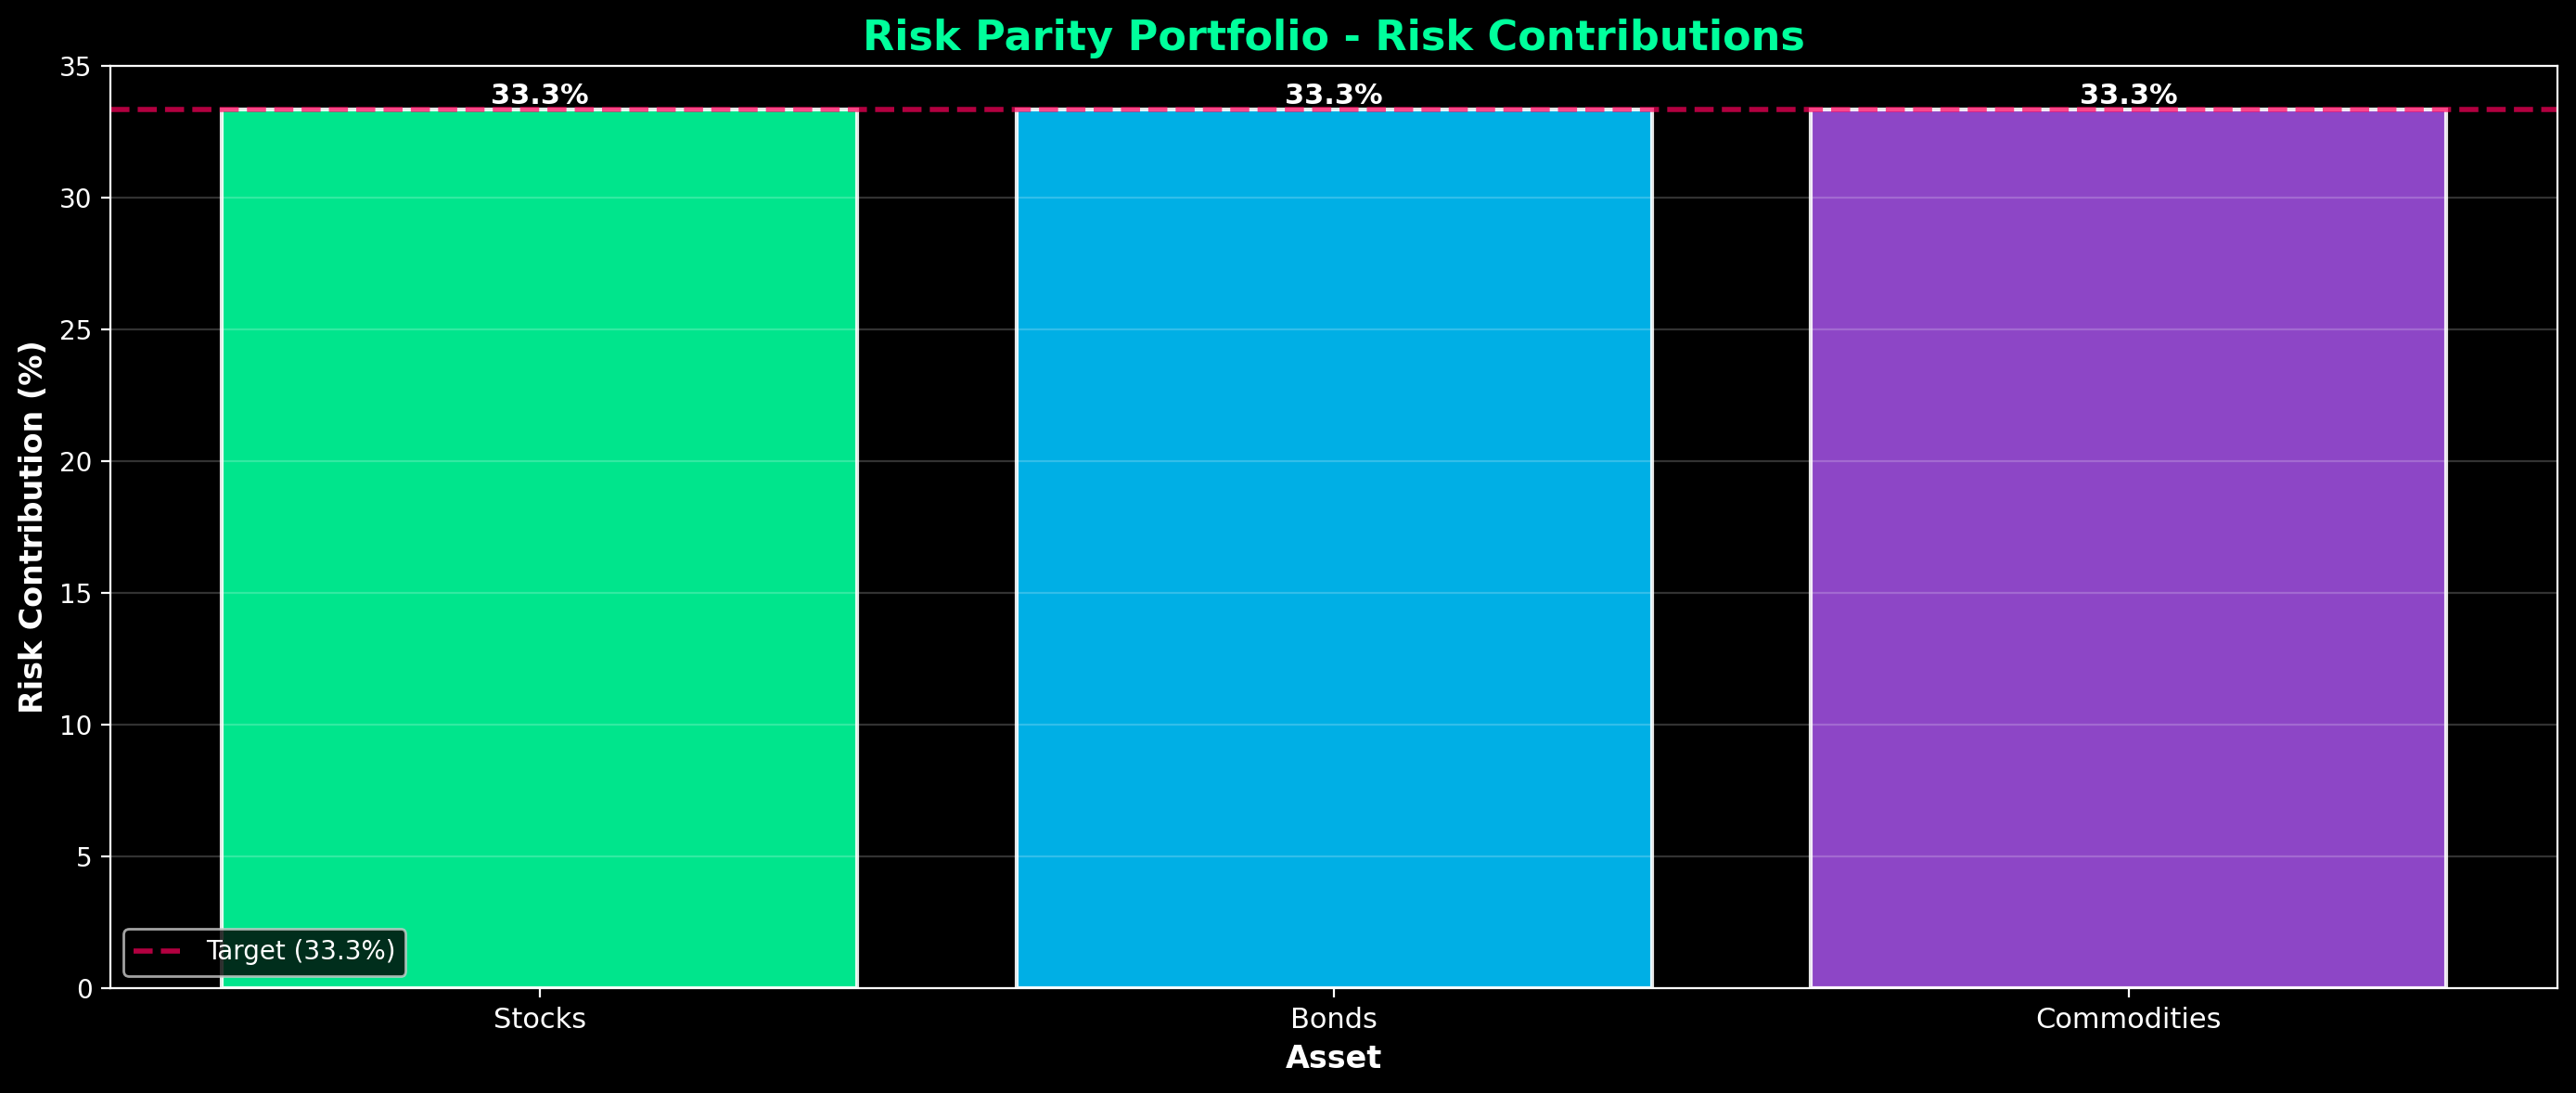


📊 Risk Contributions:
         Asset  Risk Contribution (%)
0       Stocks                  33.33
1        Bonds                  33.34
2  Commodities                  33.34


In [22]:
# Plot risk contributions for Risk Parity
viz = PortfolioVisualizer()
fig = viz.plot_risk_contributions(
    rp_result['risk_contributions'],
    list(returns.columns),
    title='Risk Parity Portfolio - Risk Contributions',
    figsize=(14, 6)
)
plt.show()

print("\n📊 Risk Contributions:")
rc_df = pd.DataFrame({
    'Asset': returns.columns,
    'Risk Contribution (%)': rp_result['risk_contributions'] * 100
})
print(rc_df.round(2))

## 4. Create Benchmark Portfolios

In [24]:
# 60/40 Portfolio
sixty_forty_weights = optimizer.sixty_forty_portfolio(list(returns.columns))

# Equal-Weight Portfolio
equal_weights = optimizer.equal_weight_portfolio(len(returns.columns))

# Calculate risk contributions for benchmarks
sixty_forty_rc = RiskModels.calculate_risk_contributions(sixty_forty_weights, cov_matrix)
equal_weight_rc = RiskModels.calculate_risk_contributions(equal_weights, cov_matrix)

print("✅ Benchmark portfolios created")

✅ Benchmark portfolios created


## 5. Compare Risk Contributions Across Portfolios

In [28]:
# Create comparison DataFrame
risk_comparison = pd.DataFrame({
    'Risk Parity': rp_result['risk_contributions'] * 100,
    '60/40': sixty_forty_rc * 100,
    'Equal-Weight': equal_weight_rc * 100
}, index=returns.columns)

print("\n📊 Risk Contribution Comparison (%):\n")
print(risk_comparison.round(2))


📊 Risk Contribution Comparison (%):

             Risk Parity  60/40  Equal-Weight
Stocks             33.33  30.65         17.20
Bonds              33.34  69.35         71.18
Commodities        33.34   0.00         11.62


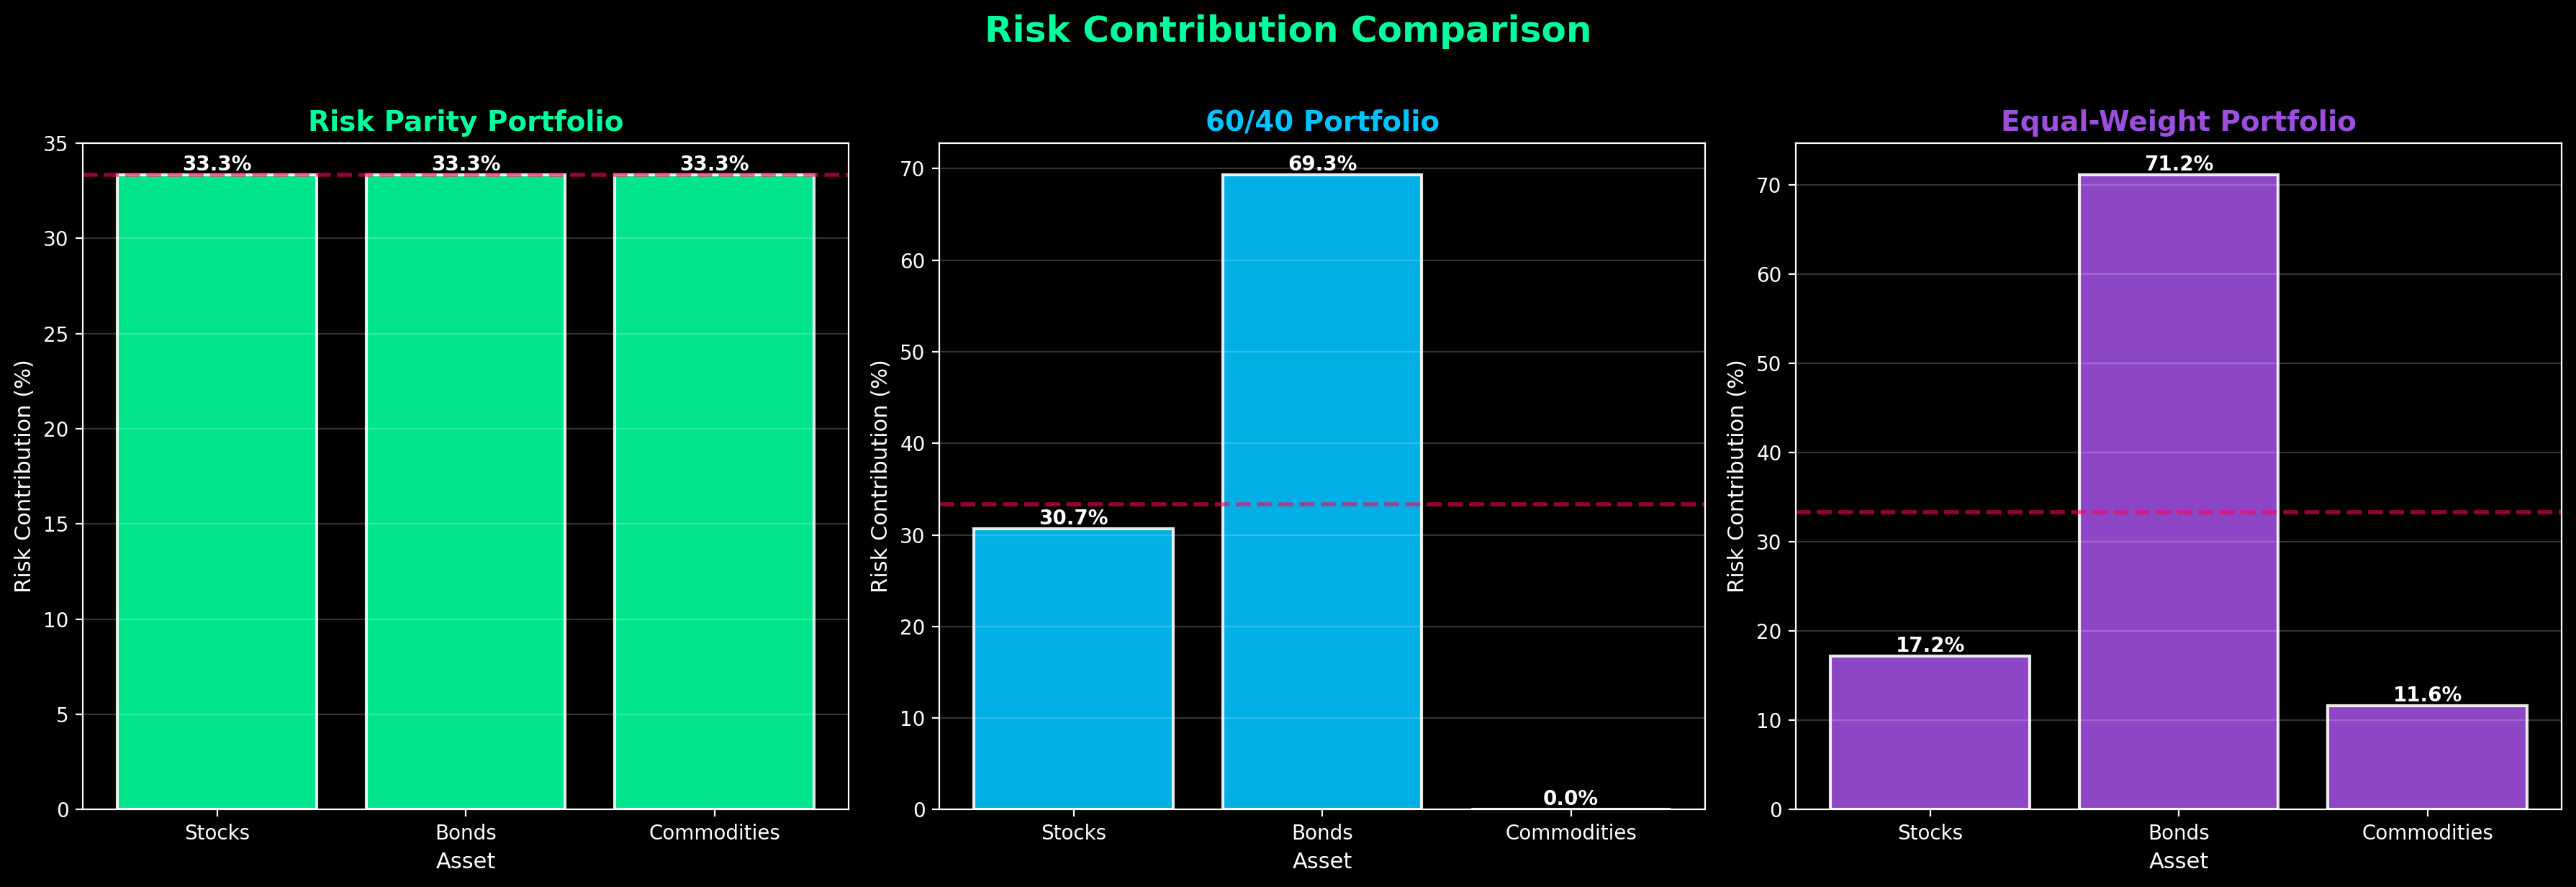

In [30]:
# Visualize risk contribution comparison
STONKS_PALETTE = ['#00ff9c', '#00c3ff', '#9d4edd']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

portfolios = [
    ('Risk Parity', rp_result['risk_contributions'], STONKS_GREEN),
    ('60/40', sixty_forty_rc, STONKS_BLUE),
    ('Equal-Weight', equal_weight_rc, '#9d4edd')
]

for idx, (name, rc, color) in enumerate(portfolios):
    ax = axes[idx]
    
    x = np.arange(len(returns.columns))
    bars = ax.bar(x, rc * 100, color=color, 
                  edgecolor='white', linewidth=1.5, alpha=0.9)
    
    # Add labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%',
               ha='center', va='bottom', 
               fontsize=10, fontweight='bold', color='white')
    
    ax.set_title(f'{name} Portfolio', fontsize=14, fontweight='bold', color=color)
    ax.set_xlabel('Asset', fontsize=11)
    ax.set_ylabel('Risk Contribution (%)', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(returns.columns, fontsize=10)
    ax.grid(True, alpha=0.2, axis='y')
    
    # Target line
    target = 100 / len(returns.columns)
    ax.axhline(y=target, color=STONKS_RED, linestyle='--', 
              linewidth=2, alpha=0.6)

plt.suptitle('Risk Contribution Comparison', 
            fontsize=18, fontweight='bold', color=STONKS_GREEN, y=1.02)
plt.tight_layout()
plt.show()

## 6. Compare Portfolio Allocations

In [32]:
# Create allocation table
allocations = optimizer.create_allocation_table({
    'Risk Parity': rp_result['weights'],
    '60/40': sixty_forty_weights,
    'Equal-Weight': equal_weights
})

print("\n📊 Portfolio Allocations (%):\n")
print(allocations)


📊 Portfolio Allocations (%):

             Risk Parity  60/40  Equal-Weight
Stocks             40.41   60.0         33.33
Bonds              15.96   40.0         33.33
Commodities        43.63    0.0         33.33


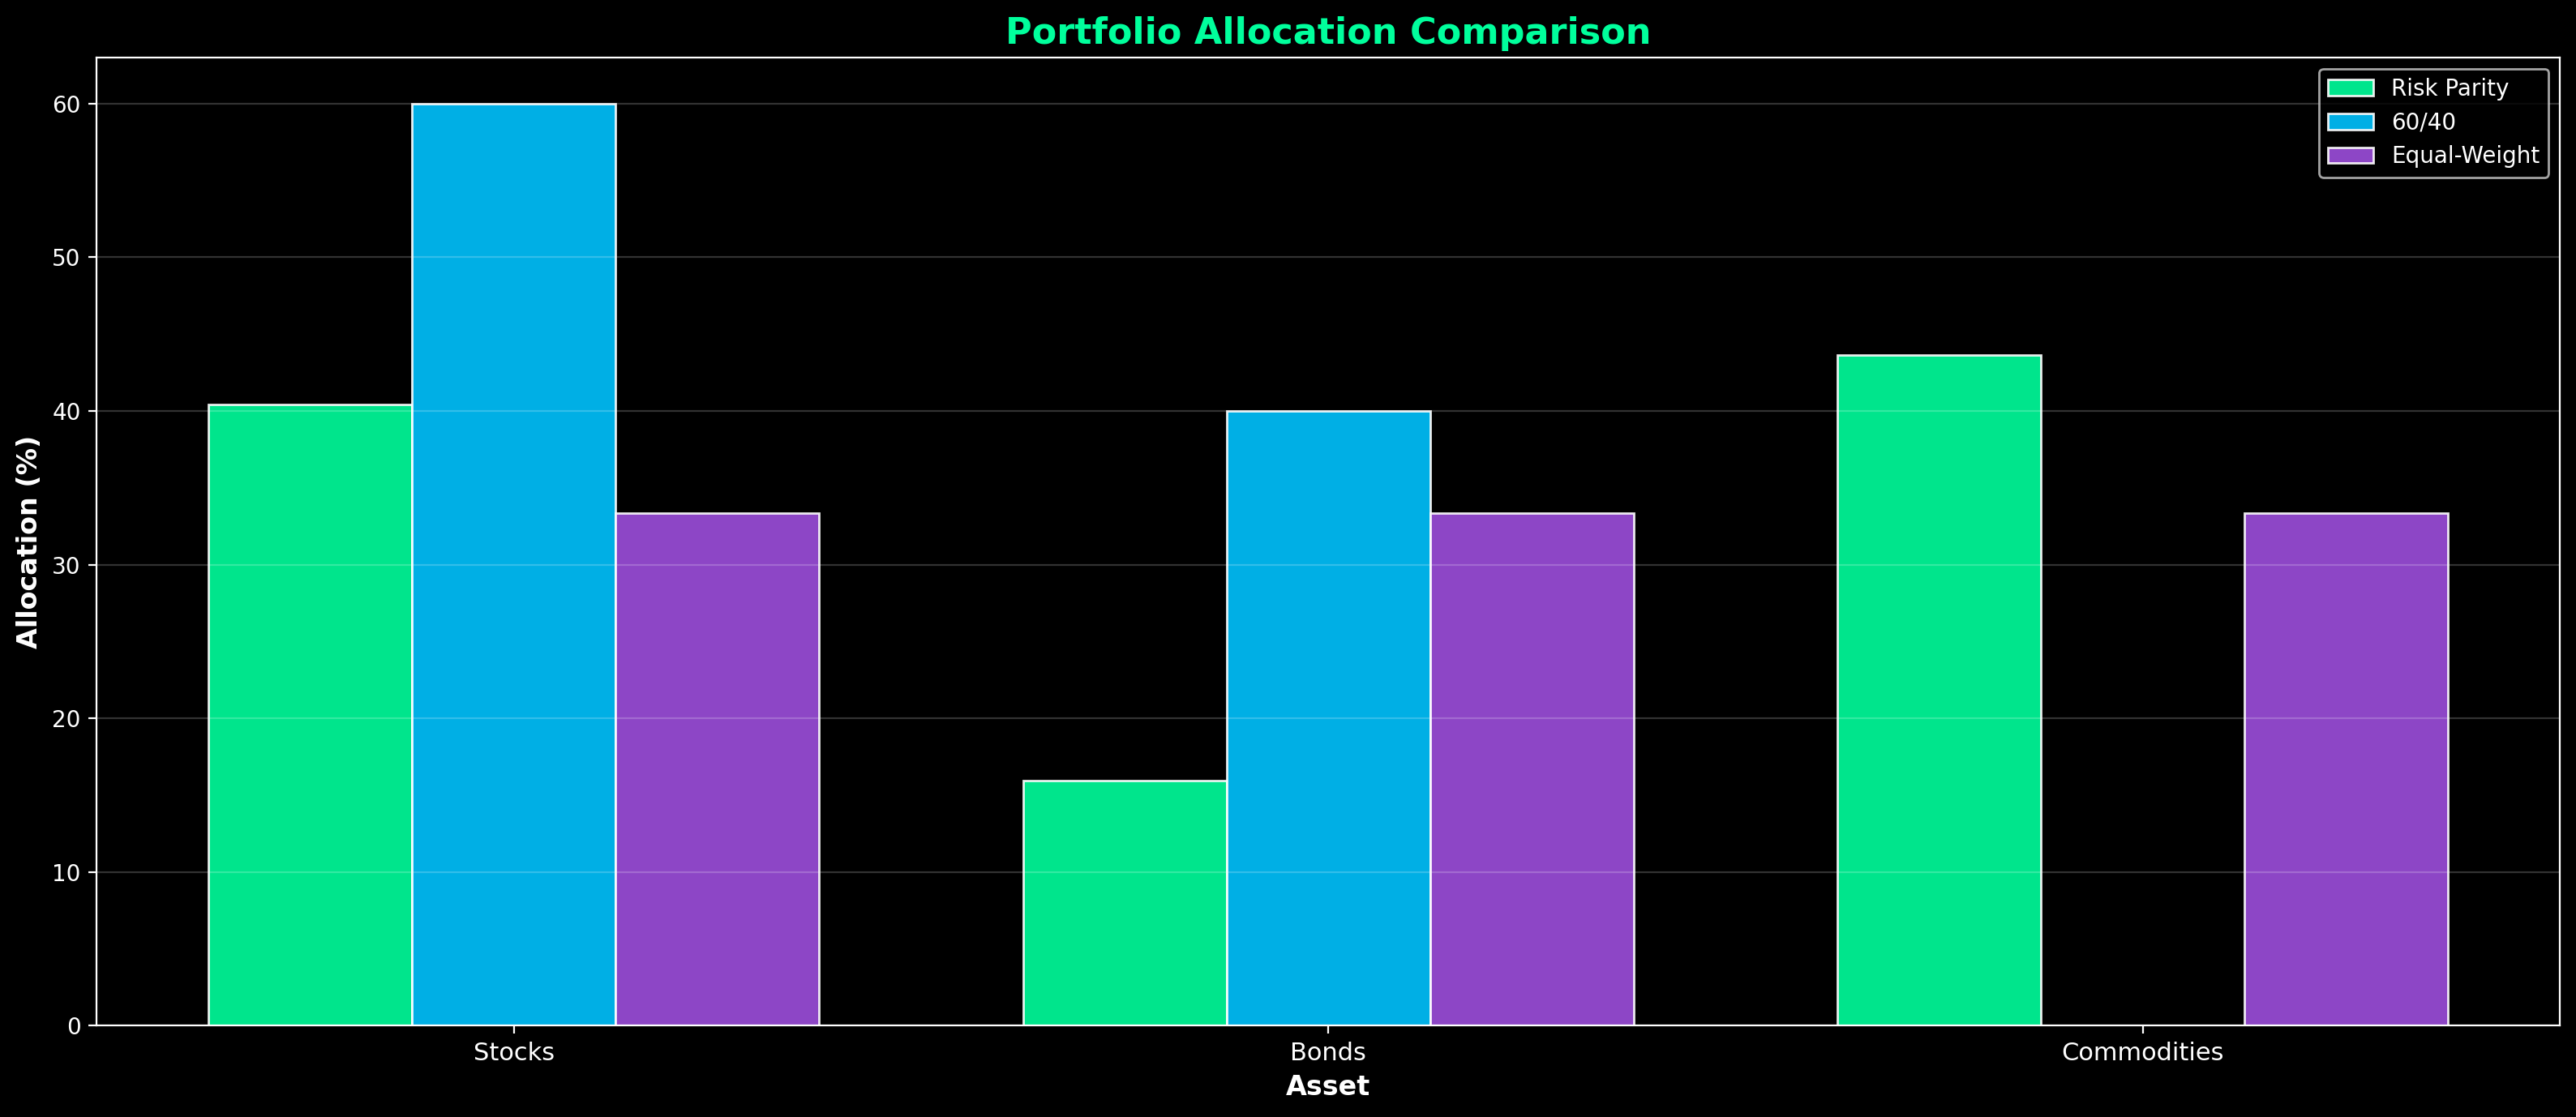

In [35]:
# Visualize allocation comparison
fig = viz.plot_allocation_comparison(allocations, figsize=(16, 7))
plt.show()

## 7. Portfolio Volatility Comparison

In [37]:
# Calculate portfolio volatilities
rp_vol = RiskModels.calculate_portfolio_volatility(rp_result['weights'], cov_matrix)
sixty_forty_vol = RiskModels.calculate_portfolio_volatility(sixty_forty_weights, cov_matrix)
equal_vol = RiskModels.calculate_portfolio_volatility(equal_weights, cov_matrix)

vol_comparison = pd.DataFrame({
    'Portfolio': ['Risk Parity', '60/40', 'Equal-Weight'],
    'Volatility': [rp_vol, sixty_forty_vol, equal_vol]
})

print("\n📊 Portfolio Volatility Comparison:\n")
print(vol_comparison.round(4))


📊 Portfolio Volatility Comparison:

      Portfolio  Volatility
0   Risk Parity      0.1430
1         60/40      0.2342
2  Equal-Weight      0.1890


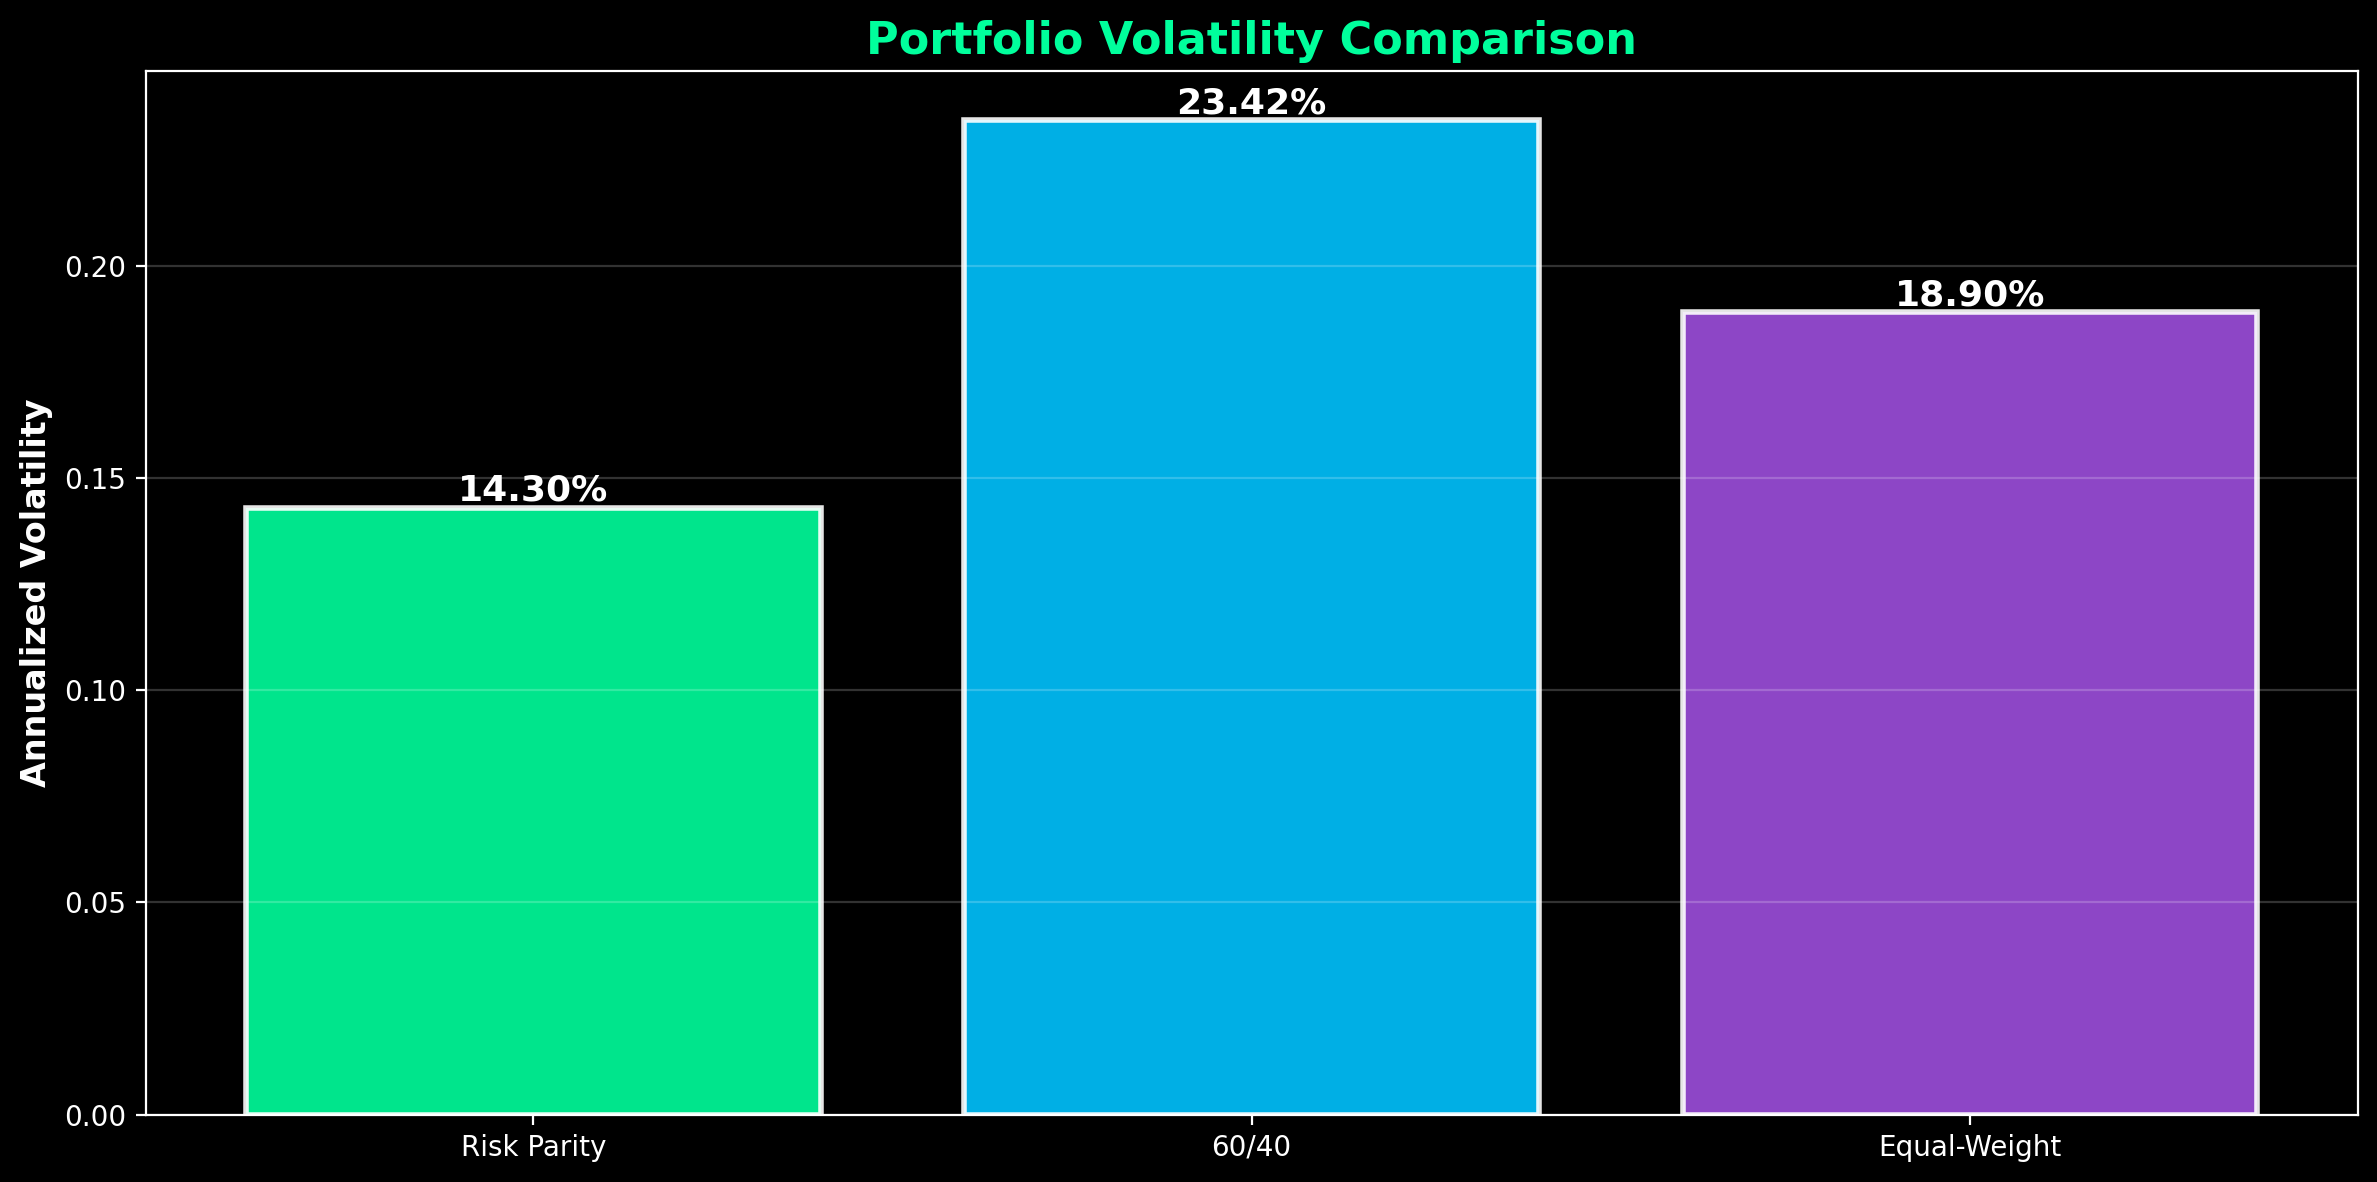

In [38]:
# Visualize volatility comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = [STONKS_GREEN, STONKS_BLUE, '#9d4edd']
bars = ax.bar(vol_comparison['Portfolio'], 
             vol_comparison['Volatility'],
             color=colors, edgecolor='white', 
             linewidth=2, alpha=0.9)

# Add labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2%}',
           ha='center', va='bottom', 
           fontsize=13, fontweight='bold', color='white')

ax.set_ylabel('Annualized Volatility', fontsize=12, fontweight='bold', color='white')
ax.set_title('Portfolio Volatility Comparison', 
            fontsize=16, fontweight='bold', color=STONKS_GREEN)
ax.grid(True, alpha=0.2, axis='y')

plt.tight_layout()
plt.show()

## 8. Key Insights

In [42]:
print("\n🔍 KEY INSIGHTS:")
print("=" * 70)

# Risk Parity characteristics
print("\n📊 RISK PARITY PORTFOLIO:")
print(f"   • Largest allocation: {returns.columns[rp_result['weights'].argmax()]} "
      f"({rp_result['weights'].max():.1%})")
print(f"   • Smallest allocation: {returns.columns[rp_result['weights'].argmin()]} "
      f"({rp_result['weights'].min():.1%})")
print(f"   • Portfolio volatility: {rp_vol:.2%}")

# 60/40 risk concentration
print("\n📊 60/40 PORTFOLIO:")
# Identify stock asset dynamically
stock_labels = ['stocks', 'equity', 'sp500', 'spy']
asset_map = {a.lower(): i for i, a in enumerate(returns.columns)}

stock_idx = next((asset_map[k] for k in stock_labels if k in asset_map), None)

if stock_idx is not None:
    stock_risk = sixty_forty_rc[stock_idx] * 100
    print(f"   • {returns.columns[stock_idx]} risk contribution: {stock_risk:.1f}% (target ≈60%)")
else:
    print("   ⚠️  Stock asset not detected — unable to compute stock risk contribution")

print(f"   • Portfolio volatility: {sixty_forty_vol:.2%}")

# Equal-Weight issues
print("\n📊 EQUAL-WEIGHT PORTFOLIO:")
max_rc = equal_weight_rc.max() * 100
max_rc_asset = returns.columns[equal_weight_rc.argmax()]
print(f"   • Largest risk contribution: {max_rc_asset} ({max_rc:.1f}%)")
print(f"   • Portfolio volatility: {equal_vol:.2%}")

print("\n" + "=" * 70)
print("\n💡 CONCLUSION:")
print("   Risk Parity achieves true risk diversification while")
print("   60/40 and Equal-Weight remain concentrated in equity risk.")
print("=" * 70)


🔍 KEY INSIGHTS:

📊 RISK PARITY PORTFOLIO:
   • Largest allocation: Commodities (43.6%)
   • Smallest allocation: Bonds (16.0%)
   • Portfolio volatility: 14.30%

📊 60/40 PORTFOLIO:
   • Stocks risk contribution: 30.7% (target ≈60%)
   • Portfolio volatility: 23.42%

📊 EQUAL-WEIGHT PORTFOLIO:
   • Largest risk contribution: Bonds (71.2%)
   • Portfolio volatility: 18.90%


💡 CONCLUSION:
   Risk Parity achieves true risk diversification while
   60/40 and Equal-Weight remain concentrated in equity risk.
